# Identifying pneumonia in X-ray images
Maciej Lorens

In [24]:
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import  models, transforms
import pytorch_lightning as pl

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Image processing
from PIL import Image
from skimage.io import imread
import cv2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style="darkgrid")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Path to the images of X-rays
data_dir = Path("chest_xray")

# Path to the train directory
train_dir = data_dir / "train"

# Path to test directory
test_dir = data_dir / "test"

In [3]:
def get_image_df(img_dir):
    # Paths to normal and pneumonia xrays
    normal_dir = img_dir / "NORMAL"
    pneumonia_dir = img_dir / "PNEUMONIA"

    # List of all the images
    normal_cases = normal_dir.glob("*.jpeg")
    pneumonia_cases = pneumonia_dir.glob("*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["Image_dir", "Label"])
    data = data.sample(frac=1).reset_index(drop=True)

    return data

In [4]:
train_data = get_image_df(train_dir)
test_data = get_image_df(test_dir)

In [5]:
train_data.head()

,Image_dir,Label
0,chest_xray/train/PNEUMONIA/person1147_virus_19...,1
1,chest_xray/train/PNEUMONIA/person1718_bacteria...,1
2,chest_xray/train/NORMAL/NORMAL2-IM-0552-0001.jpeg,0
3,chest_xray/train/PNEUMONIA/person802_bacteria_...,1
4,chest_xray/train/PNEUMONIA/person1268_bacteria...,1


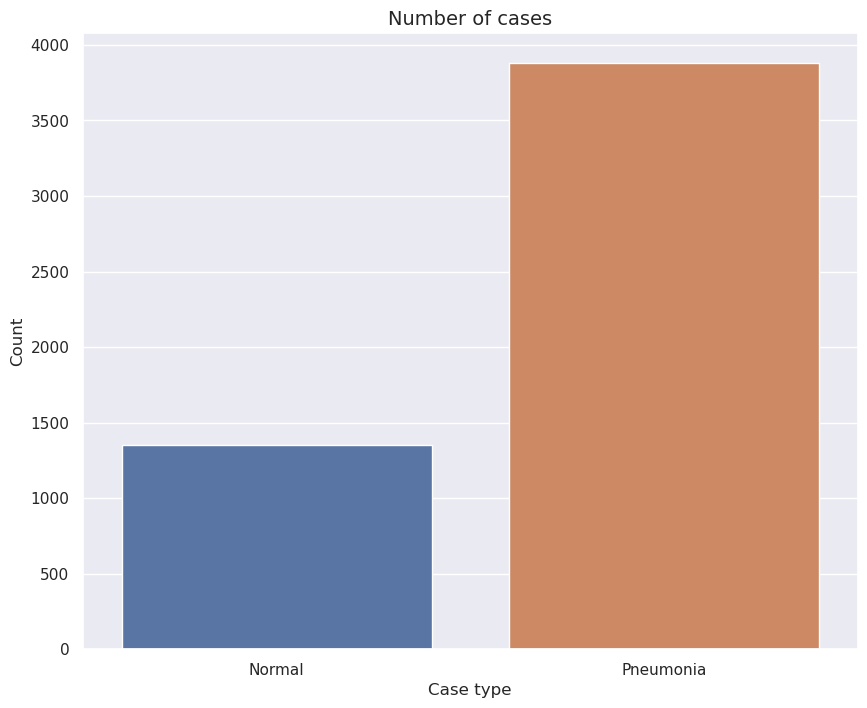

In [6]:
# Get the counts for each class
cases_count = train_data['Label'].value_counts()

# Plot the results 
plt.figure(figsize=(10,8))
sn.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

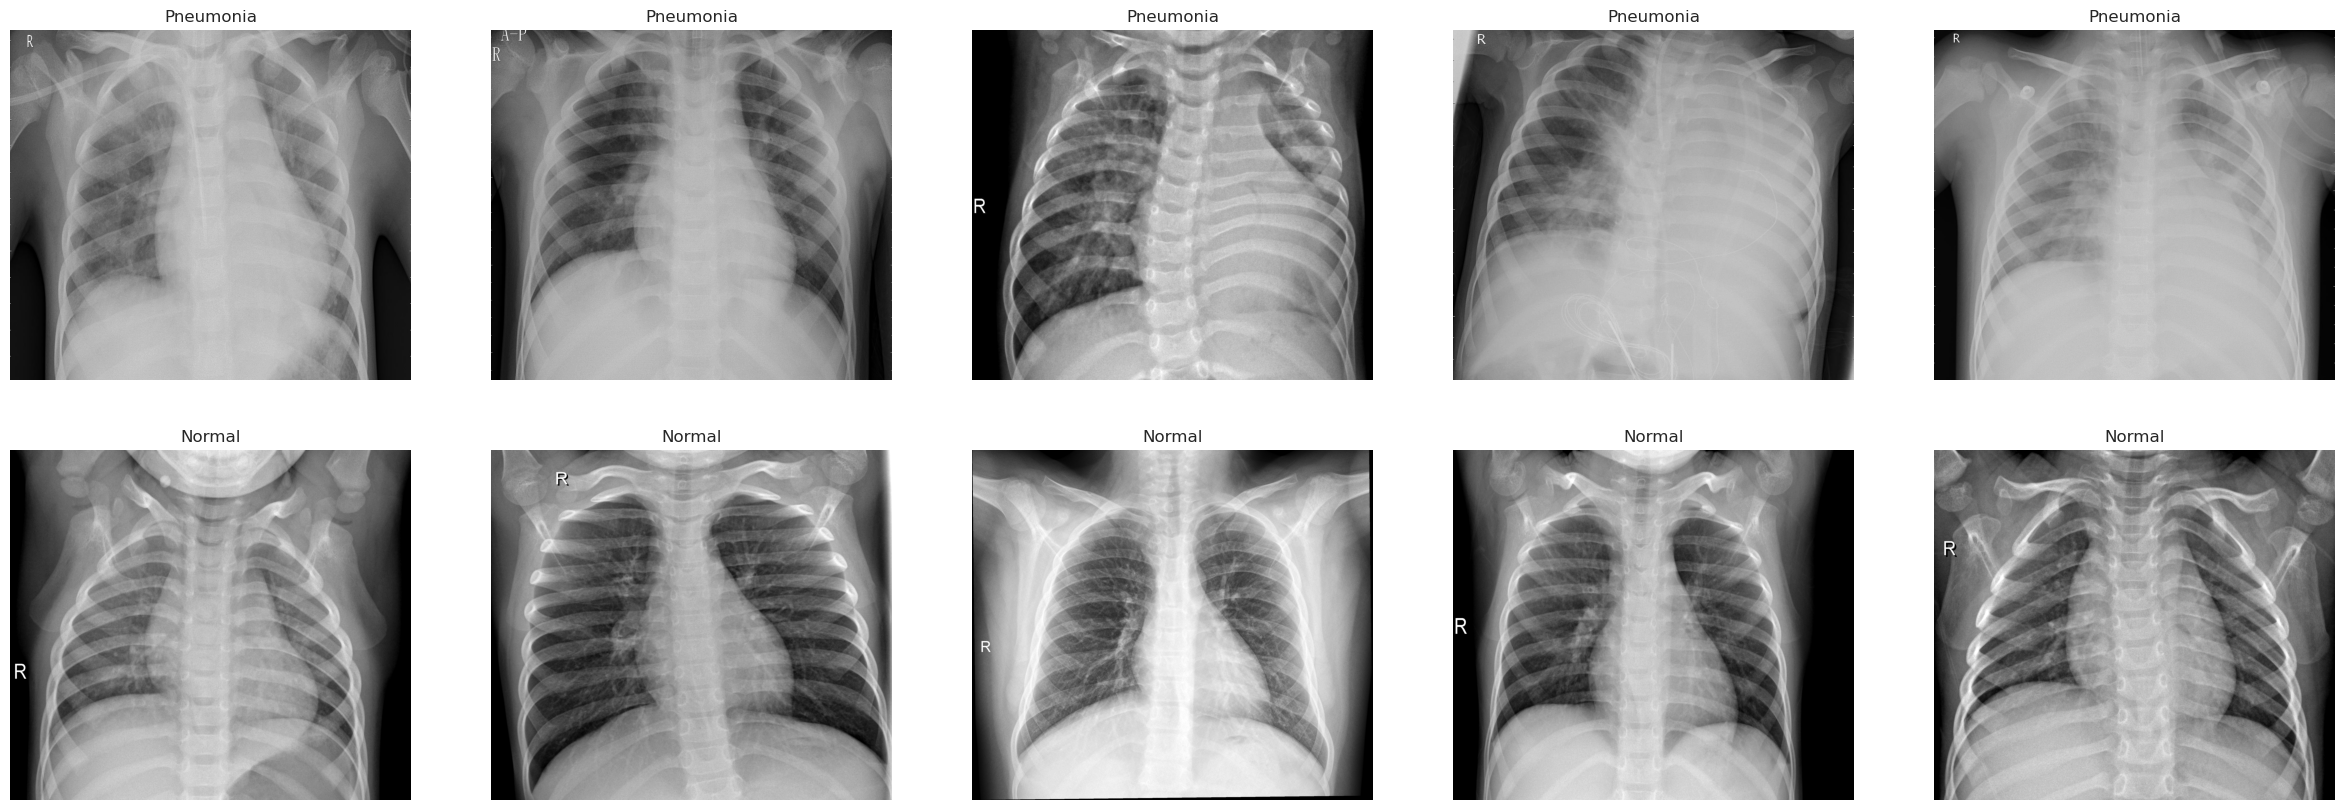

In [7]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['Label']==1]['Image_dir'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['Label']==0]['Image_dir'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [8]:
# Splitting train data into train and validation set
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=True, stratify=train_data["Label"])

In [9]:
print(f"Pneumonia cases in the trainining set: {train_data['Label'].value_counts()[1]}, Normal cases in the trainining set: {train_data['Label'].value_counts()[0]}")
print(f"Pneumonia cases in the validation set: {val_data['Label'].value_counts()[1]}, Normal cases in the validation set: {val_data['Label'].value_counts()[0]}")

Pneumonia cases in the trainining set: 3106, Normal cases in the trainining set: 1079
Pneumonia cases in the validation set: 777, Normal cases in the validation set: 270


In [18]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_dir = self.data.Image_dir[index]
        image = Image.open(image_dir)
        label = self.data.Label[index]
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [12]:
class PollutionDataLoader(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage):
        data_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.ToTensor()
        ])

        # Create three instances of the custom dataset class
        self.image_train = ImageDataset(self.train_data, transform=data_transforms)
        self.image_val = ImageDataset(self.val_data, transform=data_transforms)
        self.image_test = ImageDataset(self.test_data, transform=data_transforms)

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.image_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.image_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.image_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )